FX-only; Comparison of XGP price (USD) vs. ARPU/ARPPU (USD) within the same market; Example data, not final figures

In [3]:
import pandas as pd, numpy as np
from pathlib import Path
df = pd.read_csv(Path("..") / "data" / "sample.csv")
df.head()


,country,iso2,year,tier,price_local,currency,fx_usd_per_local,price_usd,arpu_usd,arppu_usd,source
0,United States,US,2025,Core,10.00,USD,1.00,10.00,15,25,placeholder
1,United States,US,2025,Ultimate,17.00,USD,1.00,17.00,15,25,placeholder
2,United Kingdom,GB,2025,Core,8.99,GBP,1.27,11.42,13,22,placeholder
3,United Kingdom,GB,2025,Ultimate,12.99,GBP,1.27,16.52,13,22,placeholder
4,Brazil,BR,2025,Core,34.90,BRL,0.18,6.28,7,12,placeholder


In [4]:
df["gap_arppu"]   = df["price_usd"] - df["arppu_usd"]
df["ratio_arppu"] = df["price_usd"] / df["arppu_usd"]
df["gap_arpu"]    = df["price_usd"] - df["arpu_usd"]
df["ratio_arpu"]  = df["price_usd"] / df["arpu_usd"]

q1, q3 = df["ratio_arppu"].quantile([0.25, 0.75])
iqr = q3 - q1
df["outlier_ratio_arppu"] = (df["ratio_arppu"] < (q1 - 1.5*iqr)) | (df["ratio_arppu"] > (q3 + 1.5*iqr))
df.round(3)


,country,iso2,year,tier,price_local,currency,fx_usd_per_local,price_usd,arpu_usd,arppu_usd,source,gap_arppu,ratio_arppu,gap_arpu,ratio_arpu,outlier_ratio_arppu
0,United States,US,2025,Core,10.00,USD,1.000,10.00,15,25,placeholder,-15.00,0.400,-5.00,0.667,False
1,United States,US,2025,Ultimate,17.00,USD,1.000,17.00,15,25,placeholder,-8.00,0.680,2.00,1.133,False
2,United Kingdom,GB,2025,Core,8.99,GBP,1.270,11.42,13,22,placeholder,-10.58,0.519,-1.58,0.878,False
3,United Kingdom,GB,2025,Ultimate,12.99,GBP,1.270,16.52,13,22,placeholder,-5.48,0.751,3.52,1.271,False
4,Brazil,BR,2025,Core,34.90,BRL,0.180,6.28,7,12,placeholder,-5.72,0.523,-0.72,0.897,False
5,Brazil,BR,2025,Ultimate,49.90,BRL,0.180,8.98,7,12,placeholder,-3.02,0.748,1.98,1.283,False
6,India,IN,2025,Core,349.00,INR,0.012,4.19,6,10,placeholder,-5.81,0.419,-1.81,0.698,False
7,India,IN,2025,Ultimate,599.00,INR,0.012,7.19,6,10,placeholder,-2.81,0.719,1.19,1.198,False
8,Japan,JP,2025,Core,850.00,JPY,0.006,5.53,8,13,placeholder,-7.47,0.425,-2.47,0.691,False
9,Japan,JP,2025,Ultimate,1210.00,JPY,0.006,7.87,8,13,placeholder,-5.13,0.605,-0.13,0.984,False


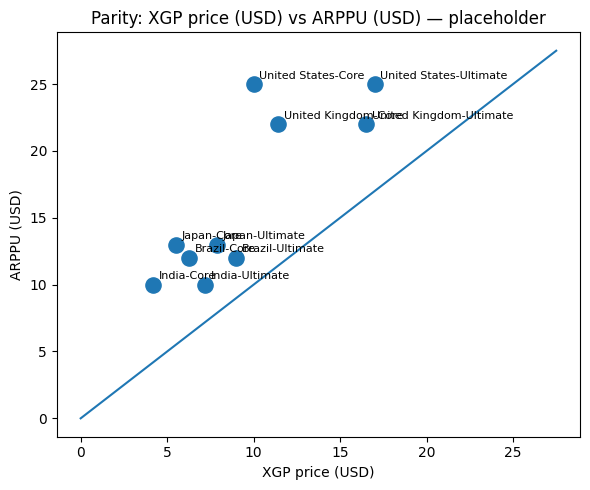

In [16]:
import matplotlib.pyplot as plt
from pathlib import Path

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(df["price_usd"], df["arppu_usd"], s=120)

xymax = max(df["price_usd"].max(), df["arppu_usd"].max()) * 1.1
ax.plot([0, xymax], [0, xymax])

for _, r in df.iterrows():
    ax.annotate(f"{r['country']}-{r['tier']}",
                (r["price_usd"], r["arppu_usd"]),
                fontsize=8, xytext=(4,4), textcoords="offset points")

ax.set_title("Parity: XGP price (USD) vs ARPPU (USD) — placeholder")
ax.set_xlabel("XGP price (USD)")
ax.set_ylabel("ARPPU (USD)")
plt.tight_layout()

out_dir = Path("..") / "figures"
out_dir.mkdir(exist_ok=True)
fig.savefig(out_dir / "parity_scatter.png", dpi=160, bbox_inches="tight")

plt.show()
plt.close(fig)

In [6]:
cols = ["country","tier","year","price_usd","arppu_usd","gap_arppu","ratio_arppu","outlier_ratio_arppu"]
league = df[cols].sort_values("ratio_arppu").reset_index(drop=True)
league.round(3)


,country,tier,year,price_usd,arppu_usd,gap_arppu,ratio_arppu,outlier_ratio_arppu
0,United States,Core,2025,10.00,25,-15.00,0.400,False
1,India,Core,2025,4.19,10,-5.81,0.419,False
2,Japan,Core,2025,5.53,13,-7.47,0.425,False
3,United Kingdom,Core,2025,11.42,22,-10.58,0.519,False
4,Brazil,Core,2025,6.28,12,-5.72,0.523,False
5,Japan,Ultimate,2025,7.87,13,-5.13,0.605,False
6,United States,Ultimate,2025,17.00,25,-8.00,0.680,False
7,India,Ultimate,2025,7.19,10,-2.81,0.719,False
8,Brazil,Ultimate,2025,8.98,12,-3.02,0.748,False
9,United Kingdom,Ultimate,2025,16.52,22,-5.48,0.751,False


In [7]:
adoption_factor = 0.3
ceiling_theoretical = (df["arppu_usd"] / df["price_usd"]).clip(upper=10)
df["ceiling_practical_toy"] = (ceiling_theoretical * adoption_factor).round(2)
df[["country","tier","price_usd","arppu_usd","ceiling_practical_toy"]]


,country,tier,price_usd,arppu_usd,ceiling_practical_toy
0,United States,Core,10.00,25,0.75
1,United States,Ultimate,17.00,25,0.44
2,United Kingdom,Core,11.42,22,0.58
3,United Kingdom,Ultimate,16.52,22,0.40
4,Brazil,Core,6.28,12,0.57
5,Brazil,Ultimate,8.98,12,0.40
6,India,Core,4.19,10,0.72
7,India,Ultimate,7.19,10,0.42
8,Japan,Core,5.53,13,0.71
9,Japan,Ultimate,7.87,13,0.50
